In [1]:
import warnings
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import simdjson
from pydantic import BaseModel
from rich import print

warnings.filterwarnings("ignore")

from xdf_types import XDFData

# Set style for better-looking plots
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (16, 9)  # 16:9 aspect ratio for presentations

In [2]:
class AnswerRound(BaseModel):
    round_number: int
    latency_applied: int  # Actual latency in milliseconds from LatencyMarkers stream
    blocks_moved: int  # Number of blocks moved during this round (from BoxBlockMarkers)
    delays_experienced: int  # Answer to "Did you experience delays..."
    task_difficulty: int  # Answer to "How difficult was it..."
    felt_controlling: int  # Answer to "I felt like I was controlling..."
    felt_part_of_body: int  # Answer to "It felt like the robot was part of my body"


class Participant(BaseModel):
    submission_id: int
    created: str
    participant_number: int
    gender: str
    age: int
    dominant_hand: str  # Can be "Right hand", "Left hand", "Ambidextrous", etc.
    robotics_experience: int
    answer_time_ms: float
    rounds: list[AnswerRound]


# 4: Has 3 different XDF files
# 33: Doesn't have ExpMarkers
ignored_participants = [4, 33]

In [3]:
questionnaire_df = pd.read_csv(
    "data/questionnaire_data-561422-2025-11-17-1240.csv", sep=";"
)

In [4]:
# Static columns (demographics)
static_cols = [
    "$submission_id",
    "$created",
    "Participant number",
    "What is your gender",
    "How old are you?",
    "What is your dominant hand?",
    "How experienced are you with robotic systems?",
    "$answer_time_ms",
]

# The repeating question columns
repeating_questions = [
    "Did you experience delays between your actions and the robot&#39;s movements?",
    "How difficult was it to perform the task?",
    "I felt like I was controlling the movement of the robot",
    "It felt like the robot was part of my body",
]

# Count how many rounds we have
all_cols = questionnaire_df.columns.tolist()
# Remove static columns to get only repeating ones
repeating_cols = [col for col in all_cols if col not in static_cols]
num_rounds = len(repeating_cols) // len(repeating_questions)

print(f"Number of rounds: {num_rounds}")

Number of rounds: 10

In [5]:
participants: list[Participant] = []

for _, row in questionnaire_df.iterrows():
    participant_number = int(row["Participant number"])
    if participant_number in ignored_participants:
        continue

    data_file = f"./data/sub-{participant_number:03d}/sub-{participant_number:03d}_ses-_task-_run-001.json"
    json_parser = simdjson.Parser()
    data: XDFData = cast(XDFData, json_parser.load(data_file))

    # Extract latency markers from the data
    latency_markers_stream = next(
        (
            stream
            for stream in data["streams"]
            if stream["info"]["name"] == "LatencyMarkers"
        ),
        None,
    )

    if latency_markers_stream is None:
        raise ValueError(
            f"LatencyMarkers stream not found for participant {participant_number}"
        )

    # Extract latencies from condition_advance markers
    # Format: ["condition_advance|rep_1|200ms|condition_1"]
    latencies_by_round = []
    for marker in latency_markers_stream["time_series"]:
        marker_str = marker[0]
        if marker_str.startswith("condition_advance|"):
            parts = marker_str.split("|")
            if len(parts) >= 3:
                latency_str = parts[2]  # e.g., "200ms"
                latency_ms = int(latency_str.replace("ms", ""))
                latencies_by_round.append(latency_ms)

    # Extract ExpMarkers stream to count block_moved events
    # Note: Some participants have duplicate ExpMarkers streams (identical events)
    # We only need to process one of them
    exp_markers_stream = None
    for stream in data["streams"]:
        if stream["info"]["name"] == "ExpMarkers":
            exp_markers_stream = stream
            break

    if exp_markers_stream is None:
        raise ValueError(
            f"No ExpMarkers stream found for participant {participant_number}"
        )

    # Count blocks moved per round
    blocks_moved_by_round = []
    current_round_blocks = 0
    in_boxblock = False

    for i, marker in enumerate(exp_markers_stream["time_series"]):
        marker_str = marker[0]

        # Handle both practice and regular boxblock sessions
        if marker_str in ["boxblock_start", "practice_boxblock_start"]:
            # If we were already in a session, save the count first
            if in_boxblock and marker_str == "boxblock_start":
                blocks_moved_by_round.append(current_round_blocks)
            in_boxblock = True
            current_round_blocks = 0
        elif marker_str in [
            "boxblock_stop",
            "practice_boxblock_stop",
            "boxblock_end",
        ]:
            if in_boxblock:
                blocks_moved_by_round.append(current_round_blocks)
                in_boxblock = False
                current_round_blocks = 0
        elif marker_str == "block_moved" and in_boxblock:
            current_round_blocks += 1

    # Ensure we have the right number of block counts
    while len(blocks_moved_by_round) < num_rounds:
        blocks_moved_by_round.append(0)

    # Parse answer rounds
    rounds = []
    for round_idx in range(num_rounds):
        # Column names have suffixes like .1, .2, etc. (pandas duplicate column naming)
        # First occurrence has no suffix, then .1, .2, .3, etc.
        suffix = f".{round_idx}" if round_idx > 0 else ""

        round_data = AnswerRound(
            round_number=round_idx + 1,
            latency_applied=latencies_by_round[round_idx]
            if round_idx < len(latencies_by_round)
            else 0,
            blocks_moved=blocks_moved_by_round[round_idx]
            if round_idx < len(blocks_moved_by_round)
            else 0,
            delays_experienced=int(row[f"{repeating_questions[0]}{suffix}"]),
            task_difficulty=int(row[f"{repeating_questions[1]}{suffix}"]),
            felt_controlling=int(row[f"{repeating_questions[2]}{suffix}"]),
            felt_part_of_body=int(row[f"{repeating_questions[3]}{suffix}"]),
        )
        rounds.append(round_data)

    # Create participant with all rounds
    participant = Participant(
        submission_id=int(row["$submission_id"]),
        created=str(row["$created"]),
        participant_number=participant_number,
        gender=str(row["What is your gender"]),
        age=int(row["How old are you?"]),
        dominant_hand=str(row["What is your dominant hand?"]),
        robotics_experience=int(row["How experienced are you with robotic systems?"]),
        answer_time_ms=float(row["$answer_time_ms"]),
        rounds=rounds,
    )
    participants.append(participant)

In [18]:
print(f"Total participants: {len(participants)}")
print(f"Total rounds per participant: {num_rounds}")

Total participants: 33

Total rounds per participant: 10

In [7]:
data_rows = []
for participant in participants:
    for round_data in participant.rounds:
        data_rows.append(
            {
                "participant_number": participant.participant_number,
                "round_number": round_data.round_number,
                "latency_applied": round_data.latency_applied,
                "delays_experienced": round_data.delays_experienced,
                "task_difficulty": round_data.task_difficulty,
                "felt_controlling": round_data.felt_controlling,
                "felt_part_of_body": round_data.felt_part_of_body,
                "blocks_moved": round_data.blocks_moved,
                "age": participant.age,
                "gender": participant.gender,
                "robotics_experience": participant.robotics_experience,
            }
        )

df_long = pd.DataFrame(data_rows)

print("Data structure:")
print(df_long.head(10))
print(f"Shape: {df_long.shape}")
print(f"Unique latency conditions: {sorted(df_long['latency_applied'].unique())}")

Data structure:

participant_number  round_number  latency_applied  delays_experienced  \
0                   1             1              200                   2   
1                   1             2               50                   2   
2                   1             3              150                   2   
3                   1             4              100                   2   
4                   1             5                0                   2   
5                   1             6              150                   3   
6                   1             7              200                   3   
7                   1             8               50                   2   
8                   1             9              100                   2   
9                   1            10                0                   3   

   task_difficulty  felt_controlling  felt_part_of_body  blocks_moved  age  \
0                2                 4                  1             0   24   
1                1                 4                  1             1   24   
2                2                 4                  1             4   24   
3                2                 4                  1             4   24   
4                4                 3                  1             0   24   
5                3                 3                  1             4   24   
6                3                 3                  1             6   24   
7                2                 3                  1             4   24   
8                3                 2                  1             4   24   
9                3                 3                  1             6   24   

  gender  robotics_experience  
0   Male                    1  
1   Male                    1  
2   Male                    1  
3   Male                    1  
4   Male                    1  
5   Male                    1  
6   Male                    1  
7   Male                    1  
8   Male                    1  
9   Male                    1

Shape: (330, 11)

Unique latency conditions:

In [8]:
dependent_vars = {
    "delays_experienced": "Delays Experienced (1-7)",
    "task_difficulty": "Task Difficulty (1-7)",
    "felt_controlling": "Felt Controlling Robot (1-7)",
    "felt_part_of_body": "Robot Felt Part of Body (1-7)",
}

In [9]:
anova_results = {}

for dv_name, dv_label in dependent_vars.items():
    print(f"\n{'─' * 80}")
    print(f"Analysis: {dv_label}")
    print(f"Independent Variable: Latency Applied (ms)")
    print(f"{'─' * 80}")

    # Run repeated measures ANOVA
    aov = pg.rm_anova(
        data=df_long,
        dv=dv_name,
        within="latency_applied",
        subject="participant_number",
        detailed=True,
    )

    # Extract variance components
    ss_treatment = aov.loc[aov["Source"] == "latency_applied", "SS"].values[0]
    ss_error = aov.loc[aov["Source"] == "Error", "SS"].values[0]
    df_treatment = aov.loc[aov["Source"] == "latency_applied", "DF"].values[0]
    df_error = aov.loc[aov["Source"] == "Error", "DF"].values[0]
    f_value = aov.loc[aov["Source"] == "latency_applied", "F"].values[0]
    p_value = aov.loc[aov["Source"] == "latency_applied", "p-unc"].values[0]

    # Store results
    anova_results[dv_name] = {
        "table": aov,
        "SSA": ss_treatment,
        "SSE": ss_error,
        "F": f_value,
        "p": p_value,
        "significant": p_value < 0.05,
    }

    # Print ANOVA table
    print("\nANOVA Table:")
    print(aov.to_string(index=False))

    # Print variance components (as required)
    print(f"\nVariance Components:")
    print(f"  SSA (Sum of Squares - Treatment): {ss_treatment:.4f}")
    print(f"  SSE (Sum of Squares - Error):     {ss_error:.4f}")
    print(f"  Total SS:                         {ss_treatment + ss_error:.4f}")
    print(f"  F-statistic:                      {f_value:.4f}")
    print(f"  p-value:                          {p_value:.6f}")

    if p_value < 0.05:
        print(f"  Result: SIGNIFICANT (p < 0.05) ✓")
    else:
        print(f"  Result: NOT SIGNIFICANT (p ≥ 0.05)")

────────────────────────────────────────────────────────────────────────────────

Analysis: Delays Experienced (1-7)

Independent Variable: Latency Applied (ms)

────────────────────────────────────────────────────────────────────────────────

ANOVA Table:

Source        SS  DF       MS         F        p-unc     ng2      eps
latency_applied 21.815278   4 5.453819 11.716847 4.194631e-08 0.14973 0.896486
          Error 57.718056 124 0.465468       NaN          NaN     NaN      NaN

Variance Components:

SSA (Sum of Squares - Treatment): 21.8153

SSE (Sum of Squares - Error):     57.7181

Total SS:                         79.5333

F-statistic:                      11.7168

p-value:                          0.000000

Result: SIGNIFICANT (p < 0.05) ✓

────────────────────────────────────────────────────────────────────────────────

Analysis: Task Difficulty (1-7)

Independent Variable: Latency Applied (ms)

────────────────────────────────────────────────────────────────────────────────

ANOVA Table:

Source        SS  DF       MS        F    p-unc      ng2      eps
latency_applied  6.841319   4 1.710330 4.979358 0.000934 0.081231 0.857758
          Error 42.592014 124 0.343484      NaN      NaN      NaN      NaN

Variance Components:

SSA (Sum of Squares - Treatment): 6.8413

SSE (Sum of Squares - Error):     42.5920

Total SS:                         49.4333

F-statistic:                      4.9794

p-value:                          0.000934

Result: SIGNIFICANT (p < 0.05) ✓

────────────────────────────────────────────────────────────────────────────────

Analysis: Felt Controlling Robot (1-7)

Independent Variable: Latency Applied (ms)

────────────────────────────────────────────────────────────────────────────────

ANOVA Table:

Source        SS  DF       MS        F    p-unc      ng2      eps
latency_applied  3.643403   4 0.910851 2.992291 0.021327 0.041769 0.822801
          Error 37.745486 124 0.304399      NaN      NaN      NaN      NaN

Variance Components:

SSA (Sum of Squares - Treatment): 3.6434

SSE (Sum of Squares - Error):     37.7455

Total SS:                         41.3889

F-statistic:                      2.9923

p-value:                          0.021327

Result: SIGNIFICANT (p < 0.05) ✓

────────────────────────────────────────────────────────────────────────────────

Analysis: Robot Felt Part of Body (1-7)

Independent Variable: Latency Applied (ms)

────────────────────────────────────────────────────────────────────────────────

ANOVA Table:

Source        SS  DF       MS        F    p-unc      ng2      eps
latency_applied  7.314236   4 1.828559 5.983114 0.000195 0.043224 0.883286
          Error 37.896875 124 0.305620      NaN      NaN      NaN      NaN

Variance Components:

SSA (Sum of Squares - Treatment): 7.3142

SSE (Sum of Squares - Error):     37.8969

Total SS:                         45.2111

F-statistic:                      5.9831

p-value:                          0.000195

Result: SIGNIFICANT (p < 0.05) ✓

In [10]:
posthoc_results = {}

for dv_name, dv_label in dependent_vars.items():
    if anova_results[dv_name]["significant"]:
        print(f"\n{'─' * 80}")
        print(f"Post-hoc for: {dv_label}")
        print(f"{'─' * 80}")

        # Pairwise comparisons with Bonferroni correction
        posthoc = pg.pairwise_tests(
            data=df_long,
            dv=dv_name,
            within="latency_applied",
            subject="participant_number",
            padjust="bonf",
            effsize="hedges",
        )

        posthoc_results[dv_name] = posthoc

        # Display results
        print("\nPairwise Comparisons (Bonferroni corrected):")
        print(
            posthoc[["A", "B", "T", "p-unc", "p-corr", "hedges"]].to_string(index=False)
        )

        # Highlight significant comparisons
        sig_comparisons = posthoc[posthoc["p-corr"] < 0.05]
        if len(sig_comparisons) > 0:
            print(f"\nSignificant pairwise differences (p < 0.05):")
            for _, row in sig_comparisons.iterrows():
                print(
                    f"  {row['A']}ms vs {row['B']}ms: p = {row['p-corr']:.6f}, Hedges' g = {row['hedges']:.3f}"
                )
        else:
            print("\nNo significant pairwise differences after correction.")
    else:
        print(f"\nSkipping post-hoc for '{dv_label}' (ANOVA was not significant)")

────────────────────────────────────────────────────────────────────────────────

Post-hoc for: Delays Experienced (1-7)

────────────────────────────────────────────────────────────────────────────────

Pairwise Comparisons (Bonferroni corrected):

A   B         T        p-unc   p-corr    hedges
  0  50  0.495035 6.240664e-01 1.000000  0.103869
  0 100 -2.159086 3.869748e-02 0.386975 -0.470527
  0 150 -2.410709 2.204092e-02 0.220409 -0.511405
  0 200 -5.244029 1.066785e-05 0.000107 -1.033341
 50 100 -3.118572 3.906746e-03 0.039067 -0.570338
 50 150 -3.108779 4.006395e-03 0.040064 -0.612817
 50 200 -6.777213 1.373510e-07 0.000001 -1.134758
100 150 -0.191311 8.495298e-01 1.000000 -0.033088
100 200 -2.849981 7.704977e-03 0.077050 -0.540413
150 200 -3.661339 9.271135e-04 0.009271 -0.513170

Significant pairwise differences (p < 0.05):

0ms vs 200ms: p = 0.000107, Hedges' g = -1.033

50ms vs 100ms: p = 0.039067, Hedges' g = -0.570

50ms vs 150ms: p = 0.040064, Hedges' g = -0.613

50ms vs 200ms: p = 0.000001, Hedges' g = -1.135

150ms vs 200ms: p = 0.009271, Hedges' g = -0.513

────────────────────────────────────────────────────────────────────────────────

Post-hoc for: Task Difficulty (1-7)

────────────────────────────────────────────────────────────────────────────────

Pairwise Comparisons (Bonferroni corrected):

A   B         T    p-unc   p-corr    hedges
  0  50 -0.505888 0.616514 1.000000 -0.090881
  0 100 -1.735699 0.092549 0.925489 -0.355313
  0 150 -2.446567 0.020292 0.202919 -0.544318
  0 200 -4.202447 0.000207 0.002075 -0.798505
 50 100 -1.199867 0.239281 1.000000 -0.269269
 50 150 -2.595984 0.014289 0.142890 -0.452966
 50 200 -3.612843 0.001057 0.010574 -0.711735
100 150 -0.658505 0.515075 1.000000 -0.154385
100 200 -2.272506 0.030141 0.301415 -0.411900
150 200 -1.234743 0.226204 1.000000 -0.287148

Significant pairwise differences (p < 0.05):

0ms vs 200ms: p = 0.002075, Hedges' g = -0.799

50ms vs 200ms: p = 0.010574, Hedges' g = -0.712

────────────────────────────────────────────────────────────────────────────────

Post-hoc for: Felt Controlling Robot (1-7)

────────────────────────────────────────────────────────────────────────────────

Pairwise Comparisons (Bonferroni corrected):

A   B        T    p-unc   p-corr   hedges
  0  50 0.951143 0.348889 1.000000 0.173010
  0 100 1.360944 0.183344 1.000000 0.271285
  0 150 2.213858 0.034327 0.343265 0.398246
  0 200 3.599903 0.001095 0.010951 0.589060
 50 100 0.611142 0.545562 1.000000 0.086214
 50 150 1.081170 0.287961 1.000000 0.209837
 50 200 2.188251 0.036312 0.363119 0.406298
100 150 0.593901 0.556888 1.000000 0.129194
100 200 1.640980 0.110910 1.000000 0.336174
150 200 1.201352 0.238713 1.000000 0.212654

Significant pairwise differences (p < 0.05):

0ms vs 200ms: p = 0.010951, Hedges' g = 0.589

────────────────────────────────────────────────────────────────────────────────

Post-hoc for: Robot Felt Part of Body (1-7)

────────────────────────────────────────────────────────────────────────────────

Pairwise Comparisons (Bonferroni corrected):

A   B        T    p-unc   p-corr   hedges
  0  50 1.272464 0.212670 1.000000 0.154391
  0 100 2.106035 0.043397 0.433972 0.327918
  0 150 2.665376 0.012102 0.121016 0.421739
  0 200 4.083637 0.000289 0.002894 0.616246
 50 100 1.261497 0.216540 1.000000 0.151497
 50 150 2.061245 0.047752 0.477517 0.253909
 50 200 3.258765 0.002715 0.027152 0.428230
100 150 1.000000 0.325053 1.000000 0.120729
100 200 2.306826 0.027911 0.279113 0.302258
150 200 1.340640 0.189780 1.000000 0.161836

Significant pairwise differences (p < 0.05):

0ms vs 200ms: p = 0.002894, Hedges' g = 0.616

50ms vs 200ms: p = 0.027152, Hedges' g = 0.428

In [11]:
for dv_name, dv_label in dependent_vars.items():
    print(f"\n{dv_label}:")
    desc_stats = (
        df_long.groupby("latency_applied")[dv_name]
        .agg(
            [
                ("Mean", "mean"),
                ("SD", "std"),
                ("SE", lambda x: x.std() / np.sqrt(len(x))),
                ("Min", "min"),
                ("Max", "max"),
                ("N", "count"),
            ]
        )
        .round(3)
    )
    print(desc_stats.to_string())

Delays Experienced (1-7):

Mean     SD     SE  Min  Max   N
latency_applied                                   
0                1.962  0.999  0.113    1    5  78
50               2.016  0.889  0.112    1    4  63
100              2.532  1.112  0.141    1    5  62
150              2.531  1.208  0.151    1    5  64
200              3.000  1.136  0.143    1    5  63

Task Difficulty (1-7):

Mean     SD     SE  Min  Max   N
latency_applied                                   
0                2.051  1.018  0.115    1    4  78
50               2.317  0.981  0.124    1    5  63
100              2.532  0.953  0.121    1    4  62
150              2.609  0.828  0.104    1    4  64
200              2.810  0.913  0.115    1    4  63

Felt Controlling Robot (1-7):

Mean     SD     SE  Min  Max   N
latency_applied                                   
0                3.692  1.292  0.146    1    5  78
50               3.968  0.999  0.126    1    5  63
100              3.903  0.882  0.112    1    5  62
150              3.828  0.985  0.123    1    5  64
200              3.651  1.050  0.132    2    5  63

Robot Felt Part of Body (1-7):

Mean     SD     SE  Min  Max   N
latency_applied                                   
0                2.744  1.263  0.143    1    5  78
50               2.857  1.176  0.148    1    5  63
100              2.742  1.085  0.138    1    5  62
150              2.609  1.203  0.150    1    5  64
200              2.460  1.075  0.135    1    5  63

✓ Saved box plots to 'plots/anova_boxplots.png'

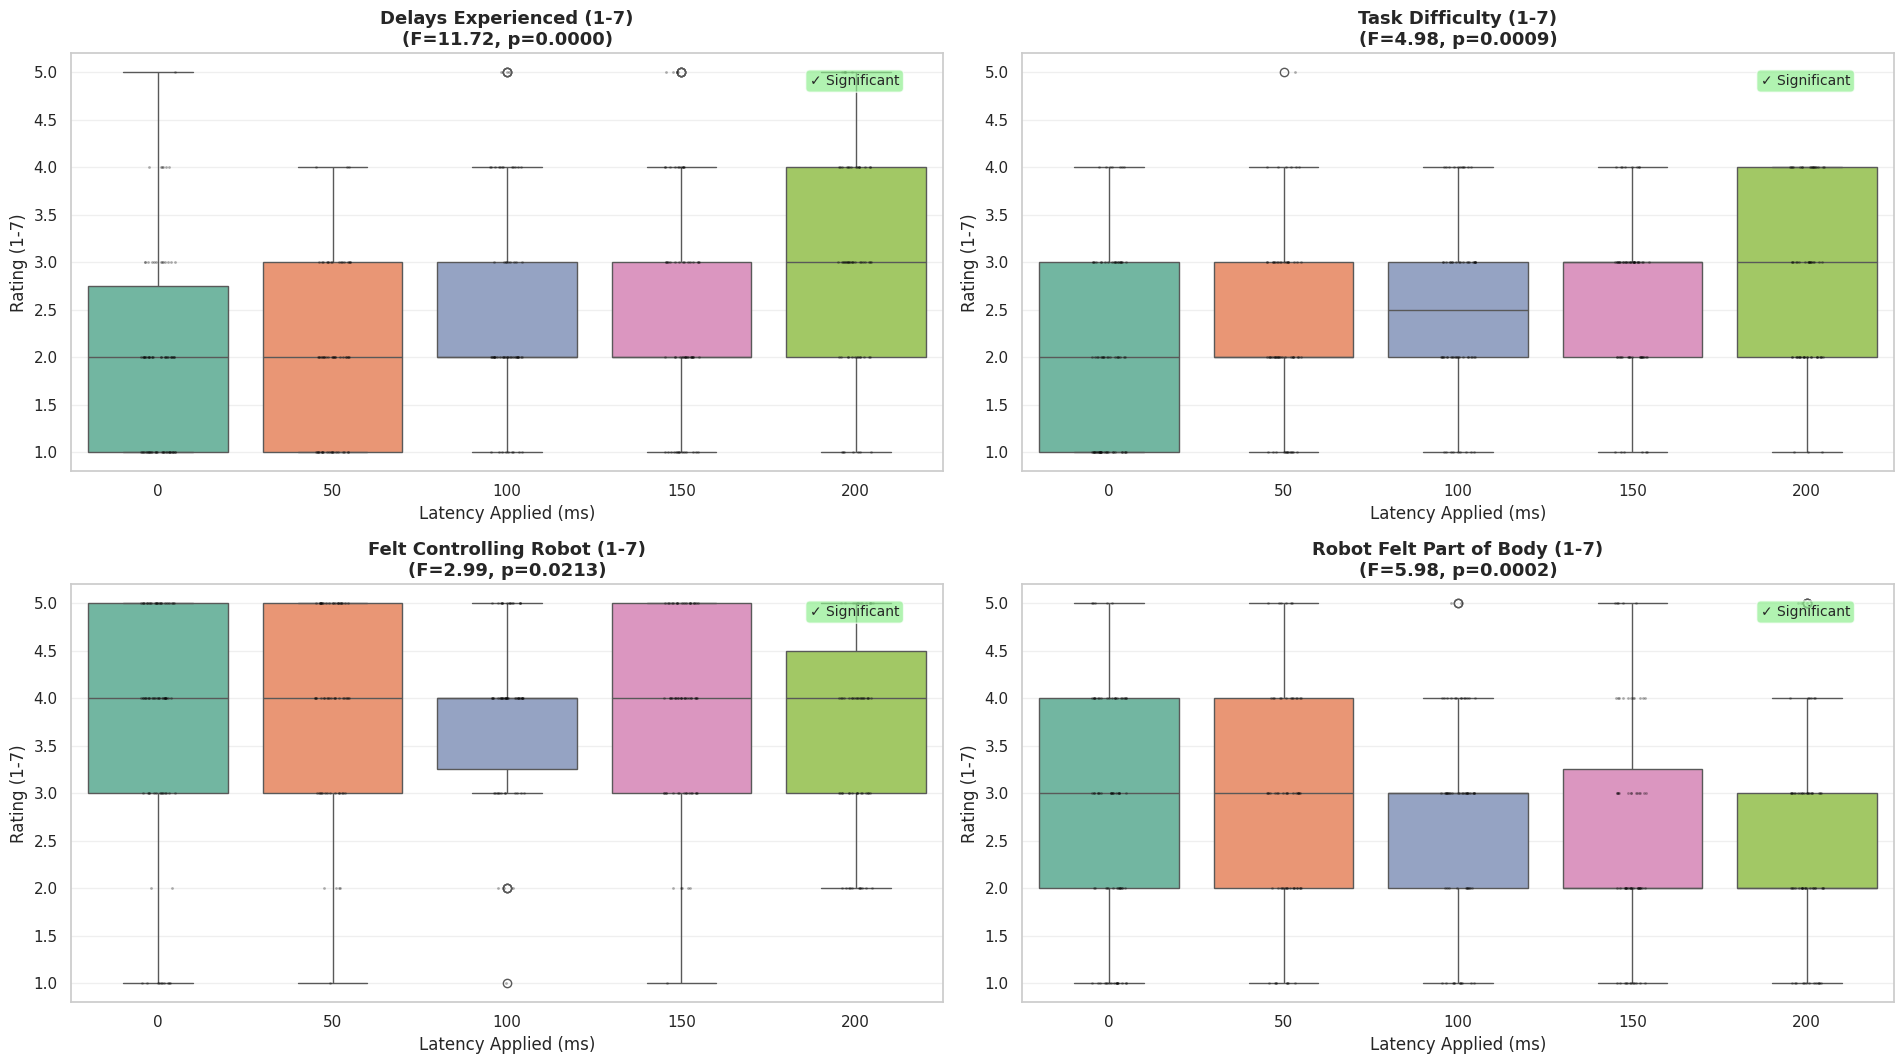

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(19.2, 10.8))  # 16:9 aspect ratio
axes = axes.flatten()

for idx, (dv_name, dv_label) in enumerate(dependent_vars.items()):
    ax = axes[idx]

    # Create box plot
    sns.boxplot(data=df_long, x="latency_applied", y=dv_name, ax=ax, palette="Set2")

    # Add individual points with jitter
    sns.stripplot(
        data=df_long,
        x="latency_applied",
        y=dv_name,
        ax=ax,
        color="black",
        alpha=0.3,
        size=2,
    )

    ax.set_xlabel("Latency Applied (ms)", fontsize=12)
    ax.set_ylabel("Rating (1-7)", fontsize=12)
    ax.set_title(
        f"{dv_label}\n(F={anova_results[dv_name]['F']:.2f}, p={anova_results[dv_name]['p']:.4f})",
        fontsize=13,
        fontweight="bold",
    )

    # Add significance indicator
    if anova_results[dv_name]["significant"]:
        ax.text(
            0.95,
            0.95,
            "✓ Significant",
            transform=ax.transAxes,
            ha="right",
            va="top",
            bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.7),
            fontsize=10,
        )

    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("plots/anova_boxplots.png", dpi=300, bbox_inches="tight")
print("✓ Saved box plots to 'plots/anova_boxplots.png'")
plt.show()

✓ Saved point plots to 'plots/anova_pointplots.png'

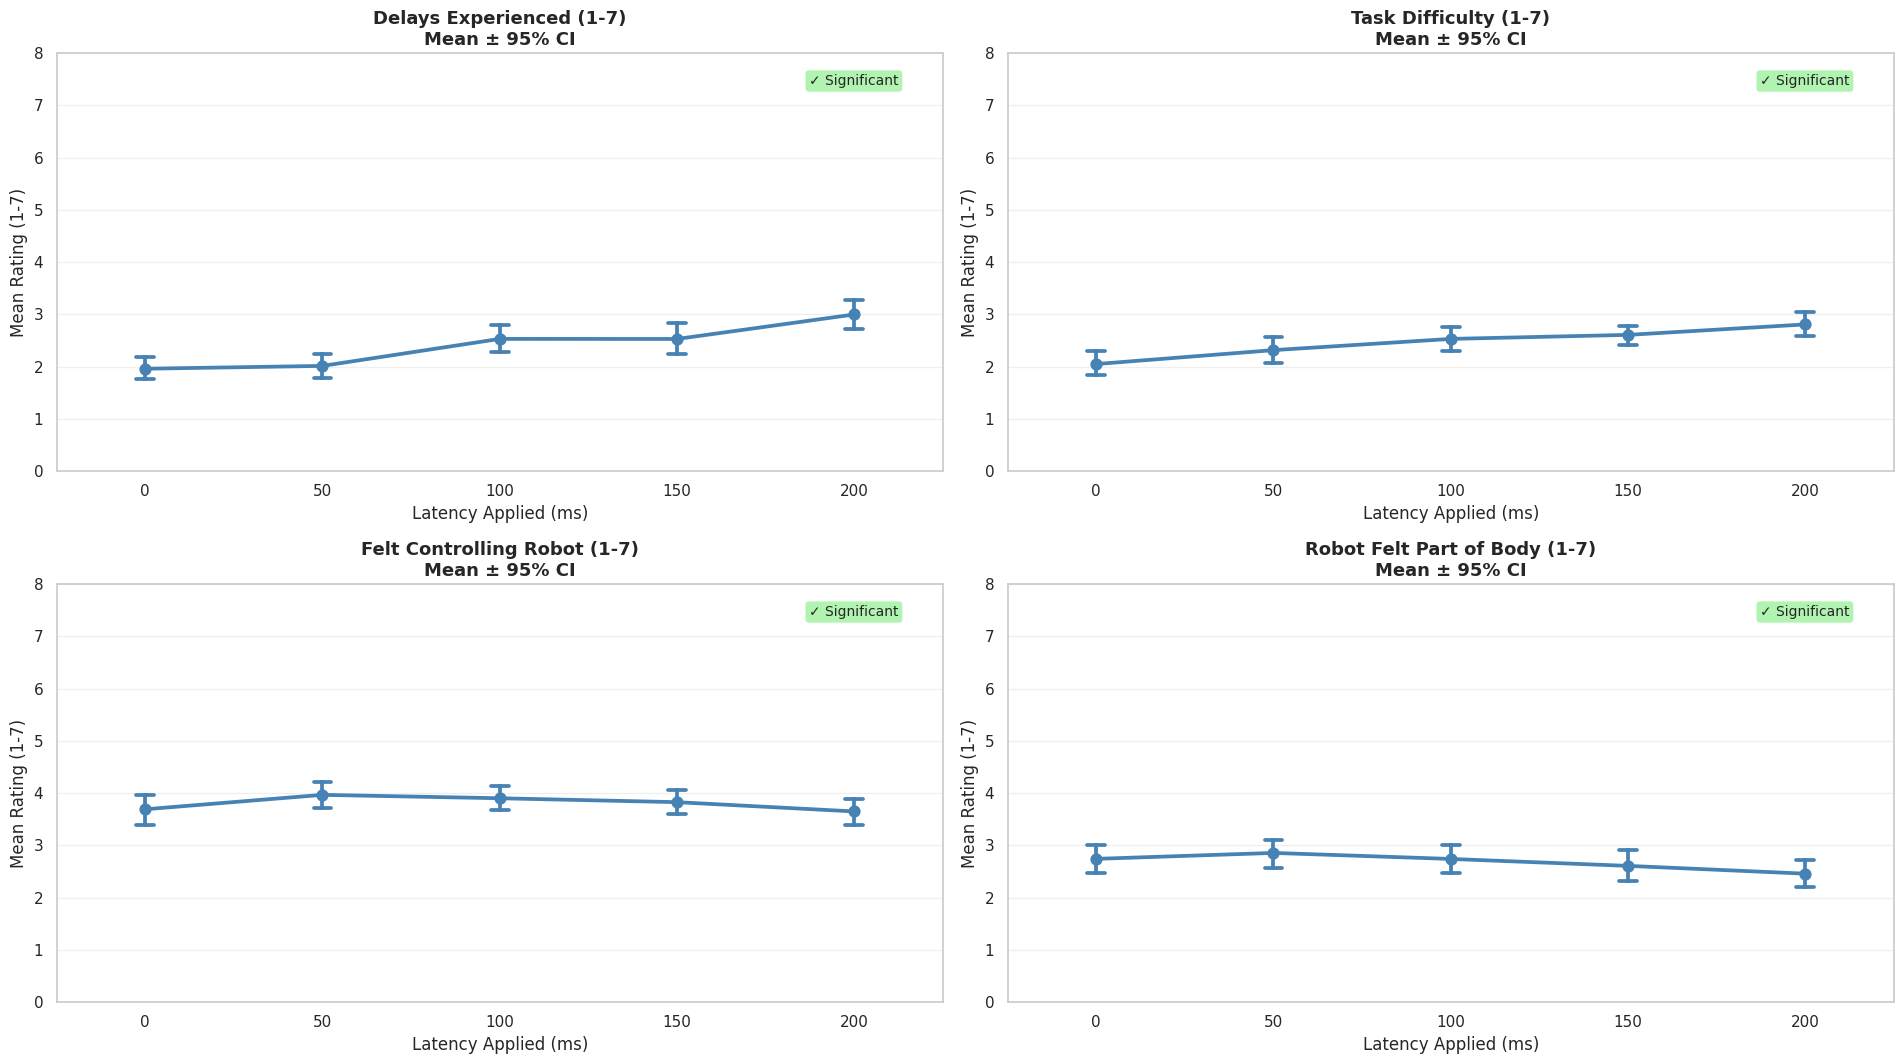

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(19.2, 10.8))  # 16:9 aspect ratio
axes = axes.flatten()

for idx, (dv_name, dv_label) in enumerate(dependent_vars.items()):
    ax = axes[idx]

    # Create point plot with 95% CI
    sns.pointplot(
        data=df_long,
        x="latency_applied",
        y=dv_name,
        ax=ax,
        errorbar="ci",
        capsize=0.1,
        color="steelblue",
        markers="o",
        linestyles="-",
    )

    ax.set_xlabel("Latency Applied (ms)", fontsize=12)
    ax.set_ylabel("Mean Rating (1-7)", fontsize=12)
    ax.set_title(f"{dv_label}\nMean ± 95% CI", fontsize=13, fontweight="bold")

    # Add significance indicator
    if anova_results[dv_name]["significant"]:
        ax.text(
            0.95,
            0.95,
            "✓ Significant",
            transform=ax.transAxes,
            ha="right",
            va="top",
            bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.7),
            fontsize=10,
        )

    ax.grid(axis="y", alpha=0.3)
    ax.set_ylim(0, 8)

plt.tight_layout()
plt.savefig("plots/anova_pointplots.png", dpi=300, bbox_inches="tight")
print("✓ Saved point plots to 'plots/anova_pointplots.png'")
plt.show()

✓ Saved violin plots to 'plots/anova_violinplots.png'

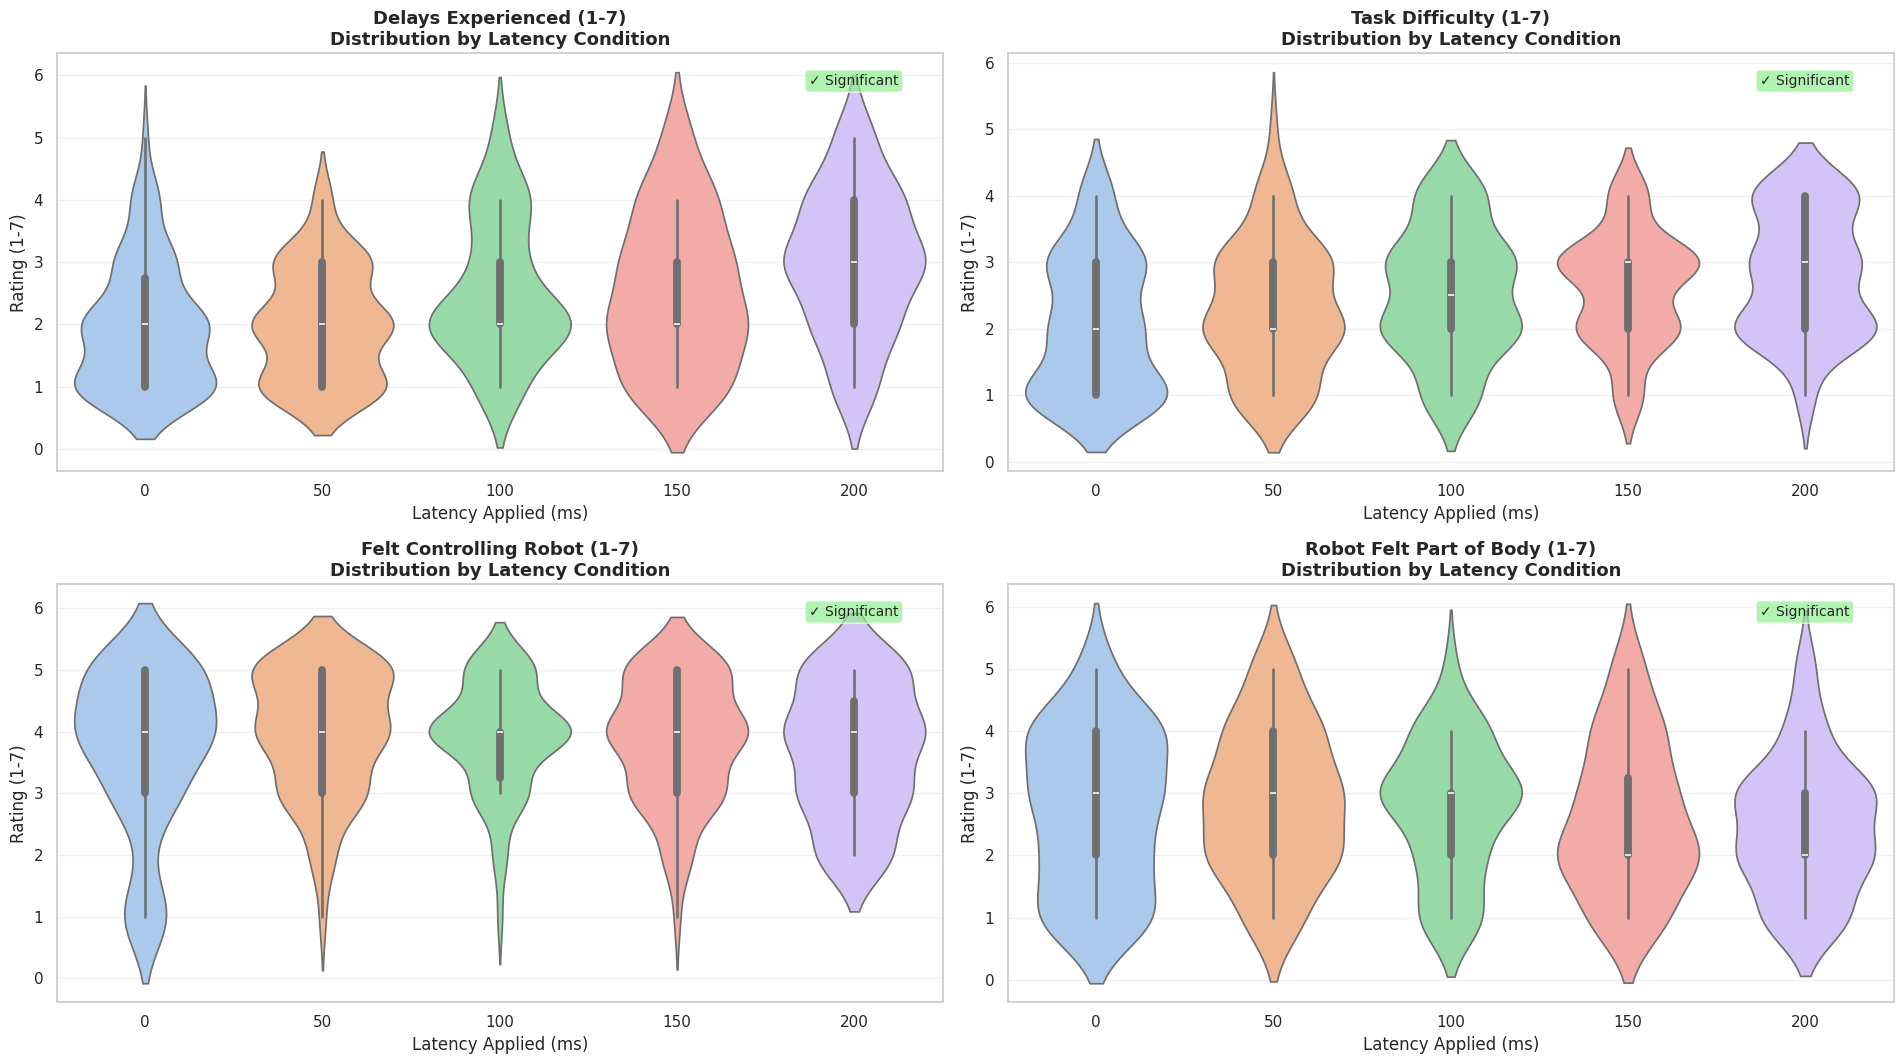

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(19.2, 10.8))  # 16:9 aspect ratio
axes = axes.flatten()

for idx, (dv_name, dv_label) in enumerate(dependent_vars.items()):
    ax = axes[idx]

    # Create violin plot
    sns.violinplot(
        data=df_long,
        x="latency_applied",
        y=dv_name,
        ax=ax,
        palette="pastel",
        inner="box",
    )

    ax.set_xlabel("Latency Applied (ms)", fontsize=12)
    ax.set_ylabel("Rating (1-7)", fontsize=12)
    ax.set_title(
        f"{dv_label}\nDistribution by Latency Condition", fontsize=13, fontweight="bold"
    )

    # Add significance indicator
    if anova_results[dv_name]["significant"]:
        ax.text(
            0.95,
            0.95,
            "✓ Significant",
            transform=ax.transAxes,
            ha="right",
            va="top",
            bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.7),
            fontsize=10,
        )

    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("plots/anova_violinplots.png", dpi=300, bbox_inches="tight")
print("✓ Saved violin plots to 'plots/anova_violinplots.png'")
plt.show()

In [15]:
summary_data = []
for dv_name, dv_label in dependent_vars.items():
    result = anova_results[dv_name]
    summary_data.append(
        {
            "Dependent Variable": dv_label,
            "SSA": f"{result['SSA']:.4f}",
            "SSE": f"{result['SSE']:.4f}",
            "F-statistic": f"{result['F']:.4f}",
            "p-value": f"{result['p']:.6f}",
            "Significant": "✓ Yes" if result["significant"] else "No",
        }
    )

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

Dependent Variable     SSA     SSE F-statistic  p-value Significant
     Delays Experienced (1-7) 21.8153 57.7181     11.7168 0.000000       ✓ Yes
        Task Difficulty (1-7)  6.8413 42.5920      4.9794 0.000934       ✓ Yes
 Felt Controlling Robot (1-7)  3.6434 37.7455      2.9923 0.021327       ✓ Yes
Robot Felt Part of Body (1-7)  7.3142 37.8969      5.9831 0.000195       ✓ Yes